In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go

In [3]:
directory = '../java/resources/results/'
all_cases_cloudlets = {}
all_cases_vms = {}
all_cases_brokers = {}

for filename in os.listdir(directory):
    
    base= os.path.basename(filename)
    name = os.path.splitext(base)[0]
    # print(i)
    
    aux_df = pd.read_csv(directory+filename+'/cloudlets_results.csv')
    aux_df.rename(columns={'Cloudlet ID':'task', 'Start Time':'start_time', 'Finish Time':'finish_time', 'Execution Time':'duration', 'VM ID':'vm'}, inplace=True)
    aux_cloudlet_chars = pd.read_csv(directory+filename+'/cloudlet_chars.csv');
    aux_cloudlet_chars.set_index('Cloudlet',inplace=True)
    all_cases_cloudlets[name] = aux_df.join(aux_cloudlet_chars,on="task")
    aux_vms = pd.read_csv(directory+filename+'/vms_results.csv')
    aux_vms.rename(columns={'VM ID':'vm', 'VM Load':'vm_load', 'Total Execution Time':'duration'}, inplace=True)
    aux_vms_chars = pd.read_csv(directory+filename+'/vms_chars.csv');
    aux_vms_chars.set_index('Vm', inplace=True)
    all_cases_vms[name] = aux_vms.join(aux_vms_chars,on="vm")
    aux_brokers = pd.read_csv(directory+filename+'/brokers_results.csv')
    aux_brokers.rename(columns={'Cpu Utilization':'utilization'}, inplace=True)
    all_cases_brokers[name] = aux_brokers
    
all_cases_cloudlets.keys()

dict_keys(['scenario-3-100', 'scenario-3-150', 'scenario-9-150', 'scenario-1-25', 'scenario-15-50', 'scenario-6-100', 'scenario-3-200', 'scenario-15-200', 'scenario-15-150', 'scenario-6-25', 'scenario-15-25', 'scenario-15-100', 'scenario-1-50', 'scenario-6-200', 'scenario-9-50', 'scenario-6-50', 'scenario-1-200', 'scenario-1-150', 'scenario-9-25', 'scenario-9-100', 'scenario-9-200', 'scenario-3-50', 'scenario-3-25', 'scenario-6-150', 'scenario-1-100'])

In [80]:
scenario = 'scenario-6-25'
current_case = all_cases_cloudlets[scenario]
current_case_vms = all_cases_vms[scenario]
current_cloudlets = all_cases_cloudlets[scenario]
scenario

'scenario-6-25'

In [81]:
current_case_vms

,Broker,vm,vm_load,duration,Pes,Mips
0,DatacenterBrokerSimple,0,0.20,380,7,302.0
1,DatacenterBrokerSimple,1,0.16,380,11,237.0
2,DatacenterBrokerSimple,2,0.16,380,12,42.0
3,DatacenterBrokerSimple,3,0.16,380,9,256.0
4,DatacenterBrokerSimple,4,0.16,380,7,379.0
5,DatacenterBrokerSimple,5,0.16,380,12,51.0
6,DatacenterBrokerPSO,0,0.20,209,7,302.0
7,DatacenterBrokerPSO,1,0.24,209,11,237.0
8,DatacenterBrokerPSO,2,0.04,209,12,42.0
9,DatacenterBrokerPSO,3,0.24,209,9,256.0


In [82]:
current_case

,Broker,task,vm,duration,start_time,finish_time,CPU Utilization Start,CPU Utilization Finish,Pes,Lenght
0,DatacenterBrokerSimple,0,0,21,0,22,1,1,4,6489
1,DatacenterBrokerSimple,16,4,22,0,22,1,1,1,8411
2,DatacenterBrokerSimple,4,4,24,0,24,1,1,4,8918
3,DatacenterBrokerSimple,7,1,29,0,29,1,1,4,6848
4,DatacenterBrokerSimple,3,3,33,0,33,1,1,2,8430
...,...,...,...,...,...,...,...,...,...,...
70,DatacenterBrokerHeuristic,16,2,202,0,202,1,1,1,8411
71,DatacenterBrokerHeuristic,15,2,203,0,203,1,1,3,8456
72,DatacenterBrokerHeuristic,18,5,135,135,270,1,1,5,6838
73,DatacenterBrokerHeuristic,14,5,162,128,290,1,1,3,8194


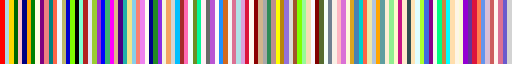

In [83]:
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, to_hex

colors = [
    'red', 'lightblue', 'gold', 'darkgreen', 'pink', 'navy', 'orange',
    'green', 'lightyellow', 'purple', 'lightcoral', 'teal', 'tomato',
    'aliceblue', 'darkkhaki', 'mediumblue', 'chartreuse', 'black',
    'aquamarine', 'firebrick', 'lavender', 'yellowgreen', 'darkorchid',
    'blue', 'mediumseagreen', 'fuchsia', 'burlywood', 'indigo',
    'lightseagreen', 'khaki', 'skyblue', 'salmon', 'violet', 'ivory',
    'darkblue', 'forestgreen', 'blueviolet', 'beige', 'sandybrown',
    'lightgray', 'deepskyblue', 'brown', 'hotpink', 'azure', 'olivedrab',
    'mediumspringgreen', 'lavenderblush', 'dimgray', 'mediumorchid',
    'snow', 'dodgerblue', 'chocolate', 'whitesmoke', 'palevioletred',
    'powderblue', 'plum', 'crimson', 'floralwhite', 'darkred', 'tan',
    'darkgray', 'seagreen', 'rosybrown', 'yellow', 'darkgoldenrod',
    'mediumpurple', 'gainsboro', 'sienna', 'chartreuse', 'palegreen',
    'wheat', 'ghostwhite', 'maroon', 'darkolivegreen', 'mintcream',
    'slategray', 'linen', 'lightpink', 'orchid', 'cornsilk', 'goldenrod',
    'steelblue', 'darkturquoise', 'tomato', 'palegoldenrod', 'lightsteelblue',
    'orange', 'cadetblue', 'papayawhip', 'lightgreen', 'lemonchiffon',
    'mediumvioletred', 'blanchedalmond', 'darkslategray', 'moccasin',
    'lightcyan', 'greenyellow', 'royalblue', 'darkmagenta', 'honeydew',
    'springgreen', 'peru', 'aqua', 'navajowhite', 'oldlace', 'lightgoldenrodyellow',
    'darkviolet', 'rebeccapurple', 'crimson', 'coral', 'cornflowerblue',
    'thistle', 'indianred', 'seashell', 'palevioletred', 'slateblue', 'lightgrey'
]
available_colors = ListedColormap(colors=[to_hex(c)for c in colors],name="my_colors")
available_colors

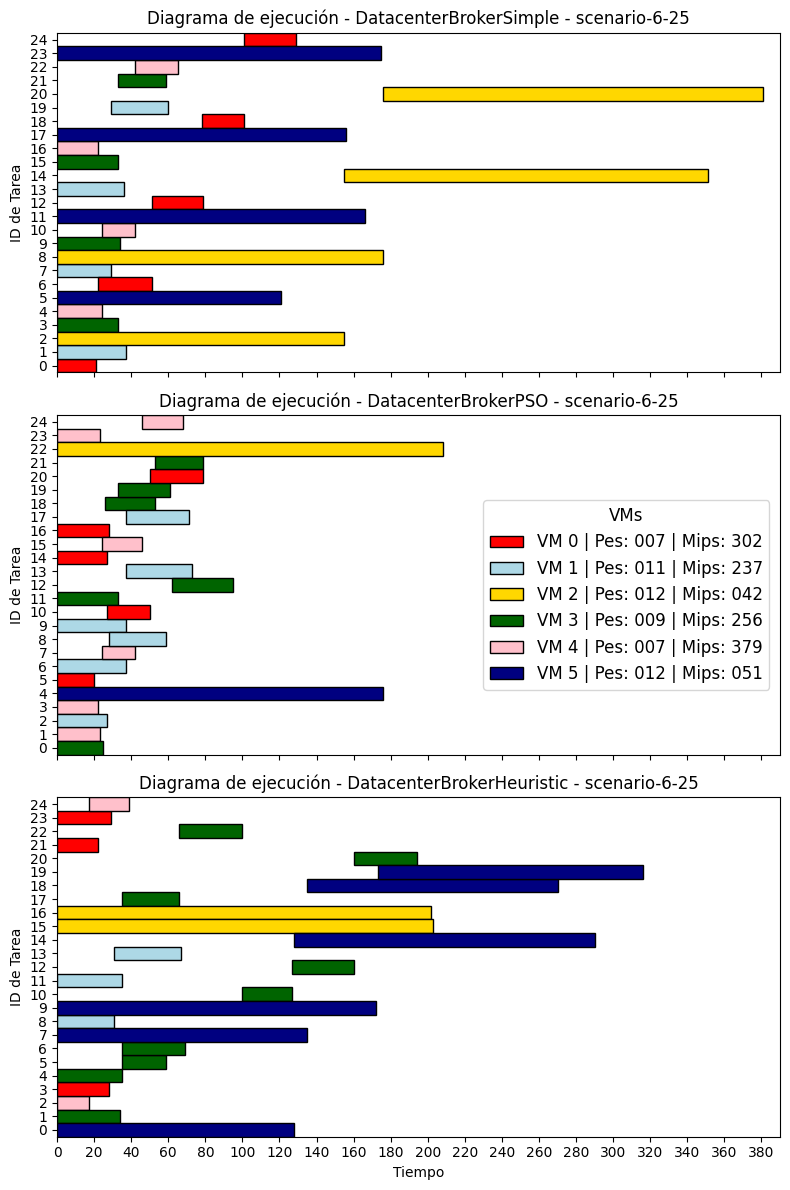

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib.axes import Axes

# Filtrar los datos por cada broker
brokers = current_case['Broker'].unique()
num_brokers = len(brokers)

# Crear subplots
fig, axs = plt.subplots(num_brokers, 1, figsize=(8, 4 * num_brokers), sharex=True)

# Asegurar que axs sea una lista, incluso si hay un solo broker
axs = axs if num_brokers > 1 else [axs]

# Crear un gráfico para cada broker
vms_df = current_case_vms.set_index(['Broker', 'vm'])

for ax, broker in zip(axs, brokers):
    broker_data = current_cloudlets[current_cloudlets['Broker'] == broker]
    
    for i, task in broker_data.iterrows():
        vm = vms_df.loc[(broker, task['vm'])]
        lab = f"VM {task['vm']} | Pes: {int(vm['Pes']):03d} | Mips: {int(vm['Mips']):03d}"
        ax.barh(y=task['task'], width=task['duration'], left=task['start_time'], 
                height=1,
                edgecolor='black',
                color=available_colors(task['vm']), 
                label=lab)

    # Configurar el eje y para mostrar números enteros o categorías
    ax.set_ylabel('ID de Tarea')
    ax.set_yticks(broker_data['task'])  # Asegura que los ticks del eje y correspondan a las tareas
    ax.set_yticklabels(broker_data['task'].astype(str), rotation=0)  # Muestra IDs como texto
    ax.set_ylim(broker_data['task'].min() - 0.5, broker_data['task'].max() + 0.5)
    ax.set_title(f'Diagrama de ejecución - {broker} - {scenario}')

ax:Axes
ax.set_xticks(range(0, int(current_cloudlets['finish_time'].max()) + 20, 20))
ax.set_xlim(0, current_cloudlets['finish_time'].max() + 10)

# Ordenar y eliminar etiquetas duplicadas
# Ordenar y Eliminar labels duplicadas
handles, labels = ax.get_legend_handles_labels()
sorted_labels = sorted(zip(labels, handles),key=lambda x: int(re.findall(r'\d{1,2}', str(x[0]))[0]))
by_label = dict(sorted_labels)  # Elimina duplicados

# Configurar el eje x compartido
axs[-1].set_xlabel('Tiempo')
fig.legend(by_label.values(), by_label.keys(),
           loc='center left', title='VMs', 
           title_fontsize='large', fontsize='large', bbox_to_anchor=(0.6, 0.5))

plt.tight_layout(rect=[0, 0, 1, 1])  # Ajustar el espacio para la leyenda
plt.show()


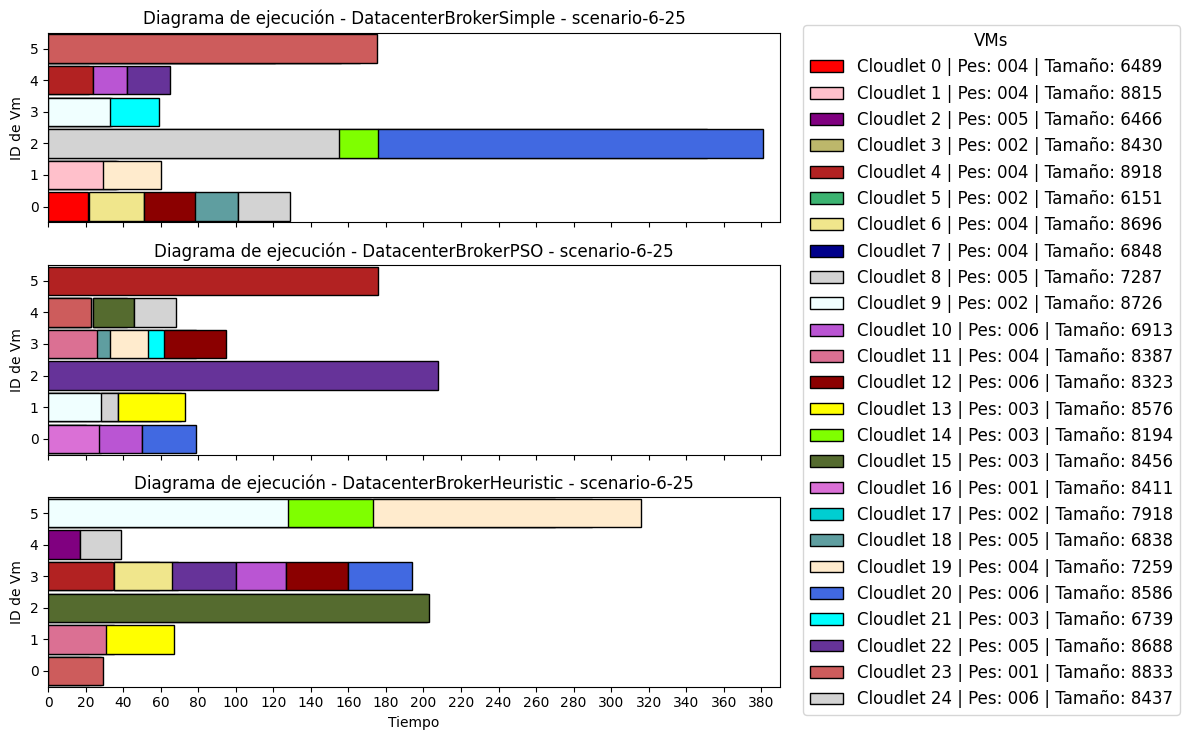

In [85]:
# Filtrar los datos por cada broker
brokers = current_case['Broker'].unique()
num_brokers = len(brokers)

# Crear subplots
fig, axs = plt.subplots(num_brokers, 1, figsize=(8, 2.5 * num_brokers), sharex=True)

# Asegurar que axs sea una lista, incluso si hay un solo broker
axs = axs if num_brokers > 1 else [axs]

# Crear un gráfico para cada broker
vms_df = current_case_vms.set_index(['Broker', 'vm'])

for ax, broker in zip(axs, brokers):
    broker_data = current_cloudlets[current_cloudlets['Broker'] == broker]
    
    for i, task in broker_data.iterrows():
        vm = vms_df.loc[(broker, task['vm'])]
        lab = f"Cloudlet {task['task']} | Pes: {int(task['Pes']):03d} | Tamaño: {int(task['Lenght']):04d}"
        ax.barh(y=task['vm'], width=task['duration'], left=task['start_time'], 
                height=0.9,
                edgecolor='black',
                color=available_colors(task['task']/current_cloudlets['task'].max()), 
                label=lab)

    # Configurar el eje y para mostrar números enteros o categorías
    ax.set_ylabel('ID de Vm')
    ax.set_yticks(broker_data['task'])  # Asegura que los ticks del eje y correspondan a las tareas
    ax.set_yticklabels(broker_data['task'].astype(str), rotation=0)  # Muestra IDs como texto
    ax.set_ylim(broker_data['vm'].min() - 0.5, broker_data['vm'].max() + 0.5)
    ax.set_title(f'Diagrama de ejecución - {broker} - {scenario}')

ax:Axes
ax.set_xticks(range(0, int(current_cloudlets['finish_time'].max()) + 20, 20))
ax.set_xlim(0, current_cloudlets['finish_time'].max() + 10)

import re

# Ordenar y Eliminar labels duplicadas
handles, labels = ax.get_legend_handles_labels()
sorted_labels = sorted(zip(labels, handles),key=lambda x: int(re.findall(r'\d{1,2}', str(x[0]))[0]))
by_label = dict(sorted_labels)  # Elimina duplicados

# Configurar el eje x compartido
axs[-1].set_xlabel('Tiempo')
fig.legend(by_label.values(), by_label.keys(),
           loc='center left', title='VMs', 
           title_fontsize='large', fontsize='large', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 1, 1])  # Ajustar el espacio para la leyenda
plt.show()


In [86]:
all_cases_brokers['scenario-15-200']['Maskespan']

0    876.08
1    534.92
2    770.60
Name: Maskespan, dtype: float64

In [87]:
# speedup (mejor maquina vs tiempo)
speedups = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    if vms == '1':
        continue
    cloudlets = scenario.split('-')[2]
    secuential_times = all_cases_brokers[f'scenario-1-{cloudlets}']
    if(cloudlets not in speedups):
        speedups[cloudlets] = {}
    if(vms not in speedups[cloudlets]):
        speedups[cloudlets][vms] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        speedups[cloudlets][vms][new_name] = float(secuential_times[secuential_times['Broker'] == broker]['Maskespan'].values[0]) / float(broker_data['Maskespan'].values[0])
    speedups[cloudlets] = dict(sorted(speedups[cloudlets].items(), key=lambda item: int(item[0])))
speedups = dict(sorted(speedups.items(), key=lambda item: int(item[0])))


In [88]:
speedups

{'25': {'3': {'Simple': 0.6986885538406636,
   'PSO': 1.8060975047276415,
   'Heuristic': 0.747161747028182},
  '6': {'Simple': 1.029552505652837,
   'PSO': 1.8788024181940313,
   'Heuristic': 1.2402761940960343},
  '9': {'Simple': 1.0840485022977686,
   'PSO': 2.2782173609495,
   'Heuristic': 1.9838889451818826},
  '15': {'Simple': 2.0532746054218447,
   'PSO': 6.328054298642534,
   'Heuristic': 2.3023283160865473}},
 '50': {'3': {'Simple': 0.9077751781925023,
   'PSO': 2.215376444031337,
   'Heuristic': 0.6886588406227815},
  '6': {'Simple': 1.4961618480522278,
   'PSO': 4.028394823256712,
   'Heuristic': 1.0407335786912857},
  '9': {'Simple': 2.0284991732321758,
   'PSO': 4.694693004671056,
   'Heuristic': 2.043155600186142},
  '15': {'Simple': 2.583782444403147,
   'PSO': 4.667375370670845,
   'Heuristic': 3.953741883501588}},
 '100': {'3': {'Simple': 0.7896220762267543,
   'PSO': 1.9995800140898499,
   'Heuristic': 0.7012376766836916},
  '6': {'Simple': 1.4913505648404504,
   'PSO

In [62]:
# import plotly.graph_objects as go

# Supongamos que 'speedups' es un diccionario con la estructura {cloudlets: {broker: speedup}}
scenario_selected = speedups['200']
# Crear el gráfico
fig = go.Figure()

color_map = {
    'Simple': 'blue',
    'PSO': 'red',
    'Heuristic': 'green'
}

show = True
# Agregar las barras para cada broker en cada escenario
for scenario, data in scenario_selected.items():
    for i, (broker, speedup) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[speedup],
            name=broker,
            legendgroup=broker,
            showlegend=show,
            text=f'{float(speedup):.2f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i,  # Asegurar que las barras estén centradas
            marker_color=color_map[broker],  # Asignar un color a cada broker
        ))
    show = False

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='Cantidad de Vms',
    yaxis_title='Speedup',
    title='Speedup de cada política al ejecutar 200 cloudlets',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1,  # Reducir la separación entre grupos de barras
    width=1000,
    height= 400,
)

# Mostrar el gráfico
fig.show()

In [63]:
# escalado de vm, fijo tareas 
# escalado de tareas, fijo vm
tiempos = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    cloudlets = scenario.split('-')[2]
    if(cloudlets not in tiempos):
        tiempos[cloudlets] = {}
    if(vms not in tiempos[cloudlets]):
        tiempos[cloudlets][vms] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        tiempos[cloudlets][vms][new_name] = float(broker_data['Maskespan'].values[0])
    tiempos[cloudlets] = dict(sorted(tiempos[cloudlets].items(), key=lambda item: int(item[0])))
tiempos = dict(sorted(tiempos.items(), key=lambda item: int(item[0])))
tiempos

{'25': {'1': {'Simple': 391.58, 'PSO': 391.58, 'Heuristic': 391.58},
  '3': {'Simple': 560.45, 'PSO': 216.81, 'Heuristic': 524.09},
  '6': {'Simple': 380.34, 'PSO': 208.42, 'Heuristic': 315.72},
  '9': {'Simple': 361.22, 'PSO': 171.88, 'Heuristic': 197.38},
  '15': {'Simple': 190.71, 'PSO': 61.88, 'Heuristic': 170.08}},
 '50': {'1': {'Simple': 834.2, 'PSO': 834.2, 'Heuristic': 834.2},
  '3': {'Simple': 918.95, 'PSO': 376.55, 'Heuristic': 1211.34},
  '6': {'Simple': 557.56, 'PSO': 207.08, 'Heuristic': 801.55},
  '9': {'Simple': 411.24, 'PSO': 177.69, 'Heuristic': 408.29},
  '15': {'Simple': 322.86, 'PSO': 178.73, 'Heuristic': 210.99}},
 '100': {'1': {'Simple': 1475.93, 'PSO': 1475.93, 'Heuristic': 1475.93},
  '3': {'Simple': 1869.16, 'PSO': 738.12, 'Heuristic': 2104.75},
  '6': {'Simple': 989.66, 'PSO': 544.7, 'Heuristic': 621.19},
  '9': {'Simple': 807.83, 'PSO': 363.67, 'Heuristic': 861.1},
  '15': {'Simple': 552.88, 'PSO': 355.88, 'Heuristic': 583.89}},
 '150': {'1': {'Simple': 2255.

In [64]:

scenario_selected = tiempos['200']
# Crear el gráfico
fig = go.Figure()

# color_map = {
#     'Simple': 'turquoise',
#     'PSO': 'orangered',
#     'Heuristic': 'wheat'
# }
show=True
# Agregar las barras para cada broker en cada escenario
for scenario, data in scenario_selected.items():
    for i, (broker, tiempo) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[tiempo],
            name=broker,
            legendgroup=broker,
            showlegend=show,
            text=f'{float(round(tiempo)):.0f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i,  # Asegurar que las barras estén centradas
            marker_color=color_map[broker],  # Asignar un color a cada broker
        ))
    show = False

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='Cantidad de Vms',
    yaxis_title='Makespan en segundos',
    title='Tiempo ejecución de 200 cloudlets por cada política',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1,  # Reducir la separación entre grupos de barras
    width=1000,
    height= 400,
)

# Mostrar el gráfico
fig.show()

In [65]:
# obtenemos los tiempos de ejecucion de cada broker en los cuales se ejecutaron con 15 vms
tiempos_vms = {}
for scenario in all_cases_brokers.keys():
    current_case = all_cases_brokers[scenario]
    vms = scenario.split('-')[1]
    cloudlets = scenario.split('-')[2]
    if(vms != '15'):
        continue
    if(cloudlets not in tiempos_vms):
        tiempos_vms[cloudlets] = {}
    if(vms not in tiempos_vms[cloudlets]):
        tiempos_vms[cloudlets] = {}

    for broker in current_case['Broker'].unique():
        if broker == 'DatacenterBrokerSimple':
            new_name = 'Simple'
        elif broker == 'DatacenterBrokerPSO':
            new_name = 'PSO'
        else:
            new_name = 'Heuristic'
        broker_data = current_case[current_case['Broker'] == broker]
        tiempos_vms[cloudlets][new_name] = float(broker_data['Maskespan'].values[0])
tiempos_vms = dict(sorted(tiempos_vms.items(), key=lambda item: int(item[0])))
# Crear el gráfico
fig = go.Figure()
# color_map = {
#     'Simple': 'turquoise',
#     'PSO': 'orangered',
#     'Heuristic': 'wheat'
# }

show = True
# Agregar las barras para cada broker en cada escenario
for scenario, data in tiempos_vms.items():
    for i, (broker, tiempo) in enumerate(data.items()):
        fig.add_trace(go.Bar(
            x=[scenario],
            y=[tiempo],
            name=broker,
            legendgroup=broker,
            showlegend=show,
            text=f'{float(tiempo):.0f}',  # Agregar información al tooltip
            hoverinfo='text',
            offsetgroup=i,  # Asegurar que las barras estén centradas
            marker_color=color_map[broker],  # Asignar un color a cada broker
        ))
    show =False

# Configurar el layout del gráfico
fig.update_layout(
    barmode='group',
    xaxis_title='Cantidad de cloudlets',
    yaxis_title='Makespan en segundos',
    title='Tiempo ejecución con 15 Vms por cada política',
    xaxis={'type': 'category'},  # Asegurar que el eje x sea categórico
    bargap=0.05,  # Reducir la separación entre barras dentro de un grupo
    bargroupgap=0.1,  # Reducir la separación entre grupos de barras
    width=1000,
    height= 400,
)

# Mostrar el gráfico
fig.show()

In [66]:
# Cargar y pivotear los datos
df_pivot = current_case_vms.pivot(index='Broker', columns='vm', values='vm_load').fillna(0)

task_counts = current_cloudlets.groupby(['Broker', 'vm']).size()
vm_color = 'blue'

# Crear el gráfico
fig = go.Figure()

for vm in df_pivot.columns:
    hover_data = []
    for broker in df_pivot.index:
        task_count = int(task_counts[broker][vm])
        task_count = task_count if task_count >= 0 else 0
        hover_data.append(f'VM {vm} (Tareas: {task_count})')
    
    vm_row = current_case_vms.loc[vm]
    lab = f"VM {vm} | Pes: {int(vm_row['Pes']):03d} | Mips: {int(vm_row['Mips']):03d}"
    fig.add_trace(go.Bar(
        x=df_pivot.index,
        y=df_pivot[vm],
        name=lab,
        hovertext=hover_data,
    ))

fig.update_layout(
    barmode='stack',
    xaxis_title='Algoritmo',
    yaxis_title='Utilización de CPU (%)',
    title='Utilización de CPU por VM por cada política'
)
fig.show()

In [ ]:
import re
def build_df(all_dict):
    """Combines all csv in one Dataframe"""
    dfs = []
    for scenario, df in all_dict.items():
        patterns = re.findall("\\d{1,3}",scenario)
        df : pd.DataFrame
        df["vm_num"] = int(patterns[0])
        df["cld_num"] = int(patterns[1])
        df = df.set_index(["cld_num"])
        dfs.append(df)
    
    return pd.concat(dfs, axis=0).groupby(["Broker","vm_num"]).apply(lambda x: x.sort_index(), include_groups=False)
brokers_df =  build_df(all_cases_brokers)
brokers_df
vms_df =  build_df(all_cases_vms)
vms_df
cloudlets_df =  build_df(all_cases_cloudlets)
cloudlets_df
brokers_df["vm_num","Maskespan"].pivot(columns=["Maskespan"])
